## 자연어 전처리-한글

In [5]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
train_data = pd.read_table('ratings_train.txt')[['document','label']]
test_data = pd.read_table('ratings_test.txt')[['document','label']]
data=pd.concat((train_data,test_data),axis=0)

In [3]:
data=data.rename(columns = {'label':'y', 'document' : 'X'})#데이터 프레임 열이름 변경

In [4]:
s_w=set(['은','는','이','가','를','들','에게','의','을','도','으로','만','라서','하다'])#불용어 정의
#s_w.add(불용어 추가문자열)#추가할 불용어는 add를 이용하여 입력
okt=Okt()#형태소 분석기(자율)

In [5]:
data.isnull().values.any()#결측치 확인

True

In [6]:
data['X'].nunique(), data['y'].nunique()#중복확인

(194543, 2)

In [7]:
data=data.drop_duplicates(subset=['X'])#중복제거
data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')#한글외 정리 
data['clean_X']=data.clean_X.str.replace('^ +','')#공백 시작문자 정리
data['clean_X']=data.clean_X.replace('',np.nan) #공백 NaN화
data=data.dropna(how='any') #NaN데이터 정리

C:\Users\student\AppData\Local\Temp/ipykernel_15080/3642056730.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')#한글외 정리
C:\Users\student\AppData\Local\Temp/ipykernel_15080/3642056730.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.clean_X.str.replace('^ +','')#공백 시작문자 정리


In [8]:
okt=Okt()
from tqdm import tqdm 
X_data=[] 
for i in tqdm(data['clean_X']): 
    tk_d=okt.morphs(i) 
    end_d=[w for w in tk_d if not w in s_w]#불용어 처리 
    X_data.append(' '.join(end_d))

100%|█████████████████████████████████████████████████████████████████████████| 193518/193518 [05:45<00:00, 559.75it/s]


In [9]:
data['y_name']=data['y']#정답 이름 기록
data['encoder_y']=LabelEncoder().fit_transform(data['y'])#정답 숫자화
data['categorical_y']=list(to_categorical(data['encoder_y']))#다중 정답을 위한 희소행렬화

In [10]:
Y=np.array(data['encoder_y'])#이진
#Y=to_categorical(data['encoder_y'])#다중

In [11]:
X=np.array(X_data)#입력정리

In [12]:
x_data,test_x,y_data,test_y = train_test_split(X,Y,test_size=0.3,random_state=0)#태스트데이터 분할

In [13]:
train_x,val_x,train_y,val_y = train_test_split(x_data,y_data,test_size=0.2,random_state=0)#학습, 검증 데이터 분할

In [14]:
(train_x.shape,train_y.shape),(test_x.shape,test_y.shape),(val_x.shape,val_y.shape)

(((108369,), (108369,)), ((58056,), (58056,)), ((27093,), (27093,)))

In [15]:
tk = Tokenizer()
tk.fit_on_texts(train_x)#문서의 단어수 확인

In [16]:
n=len([d for d in sorted(list(tk.word_counts.items()),key=lambda x:x[1]) if d[1]>4])+1#4번이하 입력단어 정리시 길이확인

In [17]:
token=Tokenizer(n)#고정된 단어수로 정리
token.fit_on_texts(train_x)

In [18]:
token_train_x=token.texts_to_sequences(train_x)
token_test_x=token.texts_to_sequences(test_x)
token_val_x=token.texts_to_sequences(val_x)

In [19]:
drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]#빈 문장 위치 정보 확인
drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]#빈 문장 위치 정보 확인
drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]#빈 문장 위치 정보 확인

In [20]:
token_train_x = np.delete(token_train_x, drop_train, axis=0)#빈 문장 정리
train_y = np.delete(train_y, drop_train, axis=0)#빈 문장 정리
token_test_x = np.delete(token_test_x, drop_test, axis=0)#빈 문장 정리
test_y = np.delete(test_y, drop_test, axis=0)#빈 문장 정리
token_val_x = np.delete(token_val_x, drop_val, axis=0)#빈 문장 정리
val_y = np.delete(val_y, drop_val, axis=0)#빈 문장 정리

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
w_l=len(pad_sequences(token_train_x)[0])#문장 길이 확인

In [22]:
train_inputs = pad_sequences(token_train_x,maxlen=w_l)#동일 문장길이화
test_inputs = pad_sequences(token_test_x,maxlen=w_l)#동일 문장길이화
val_inputs = pad_sequences(token_val_x,maxlen=w_l)#동일 문장길이화

In [23]:
train_outputs=train_y#출력정리
test_outputs=test_y#출력정리
val_outputs=val_y#출력정리

In [24]:
(train_inputs.shape,train_outputs.shape),(test_inputs.shape,test_outputs.shape),(val_inputs.shape,val_outputs.shape)

(((107910, 68), (107910,)), ((57757, 68), (57757,)), ((26965, 68), (26965,)))

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, Dense, LSTM,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)#4번연속 좋은값이 안나오면 스탑
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [26]:
model = Sequential()
model.add(Embedding(n, 100))
model.add(LSTM(128,return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [28]:
#배치사이즈로 쪼개다가 나머지가 나오면 날려버림
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_inputs, train_outputs, epochs=15, callbacks=[es, mc], batch_size=60,validation_data=(val_inputs,val_outputs))

Epoch 1/15
1799/1799 [==============================] - 193s 106ms/step - loss: 0.3832 - acc: 0.8246 - val_loss: 0.3508 - val_acc: 0.8438

Epoch 00001: val_acc improved from -inf to 0.84376, saving model to best_model.h5
Epoch 2/15
1799/1799 [==============================] - 192s 107ms/step - loss: 0.2811 - acc: 0.8788 - val_loss: 0.3533 - val_acc: 0.8461

Epoch 00002: val_acc improved from 0.84376 to 0.84610, saving model to best_model.h5
Epoch 3/15
1799/1799 [==============================] - 195s 108ms/step - loss: 0.2163 - acc: 0.9090 - val_loss: 0.3961 - val_acc: 0.8411

Epoch 00003: val_acc did not improve from 0.84610
Epoch 4/15
1799/1799 [==============================] - 201s 112ms/step - loss: 0.1571 - acc: 0.9364 - val_loss: 0.4755 - val_acc: 0.8388

Epoch 00004: val_acc did not improve from 0.84610
Epoch 5/15
1799/1799 [==============================] - 205s 114ms/step - loss: 0.1118 - acc: 0.9564 - val_loss: 0.6017 - val_acc: 0.8269

Epoch 00005: val_acc did not improve f

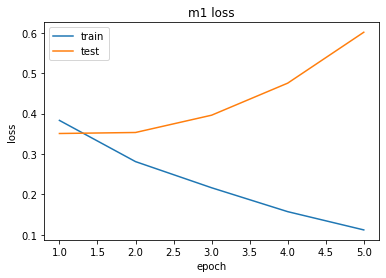

In [34]:
#가시화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('m1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(test_inputs,test_outputs)[1]

NameError: name 'load_model' is not defined

In [2]:
def 문장_전처리(문장):
    문장 = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', 문장)
    문장 = okt.morphs(문장, stem=True)
    문장 = [w for w in 문장 if not w in s_w] 
    encoded = token.texts_to_sequences([문장])
    pad_new = pad_sequences(encoded, maxlen = w_l) 
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 긍정 리뷰입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [3]:
문장_전처리('재미있는 영화였어')

NameError: name 're' is not defined

In [42]:
문장_전처리('내 인생 최악의 영화였어')

95.90% 확률로 부정 리뷰입니다.

